In [4]:
# -*- coding: utf-8 -*-
files = [
    "/msralaphilly2/ml-la/renqian/SFM/threedimargen/data/materials_data/instruct/result_collection/1b_steps/test.bandgap_to_mat.response.valid.structures/structures_1b_steps_test.bandgap_to_mat.response.valid.structures_with_bandgap.csv",
    "/msralaphilly2/ml-la/renqian/SFM/threedimargen/data/materials_data/instruct/result_collection/1b_steps/test.comp_bgap_to_material.response.valid.structures/structures_1b_steps_test.comp_bgap_to_material.response.valid.structures_with_bandgap.csv",
    "/msralaphilly2/ml-la/renqian/SFM/threedimargen/data/materials_data/instruct/result_collection/8b_steps/test.bandgap_to_mat.response.valid.structures/structures_8b_steps_test.bandgap_to_mat.response.valid.structures_with_bandgap.csv",
    "/msralaphilly2/ml-la/renqian/SFM/threedimargen/data/materials_data/instruct/result_collection/8b_steps/test.comp_bgap_to_material.response.valid.structures/structures_8b_steps_test.comp_bgap_to_material.response.valid.structures_with_bandgap.csv",
    "/msralaphilly2/ml-la/renqian/SFM/threedimargen/data/materials_data/instruct/result_collection/8x7b/global_step7755_restore_new/test.bandgap_to_mat.response.valid.structures/relaxed_atoms_with_bandgap.csv"
]
instructions = [
    "/msralaphilly2/ml-la/renqian/SFM/threedimargen/data/materials_data/instruct/base1b/instruct_task_20240807/1b_dialogue_1v1_bs2048_steps_20000/all/test.bandgap_to_mat.tsv.response.valid.inst.txt",
    "/msralaphilly2/ml-la/renqian/SFM/threedimargen/data/materials_data/instruct/base1b/instruct_task_20240807/1b_dialogue_1v1_bs2048_steps_20000/all/test.comp_bgap_to_material.tsv.response.valid.inst.txt",
    "/msralaphilly2/ml-la/renqian/SFM/threedimargen/data/materials_data/instruct/base8b/instruct_task_20240807/8b_dialogue_1v1_bs2048_steps_20000/all/test.bandgap_to_mat.tsv.response.valid.inst.txt",
    "/msralaphilly2/ml-la/renqian/SFM/threedimargen/data/materials_data/instruct/base8b/instruct_task_20240807/8b_dialogue_1v1_bs2048_steps_20000/all/test.comp_bgap_to_material.tsv.response.valid.inst.txt",
    "/msralaphilly2/ml-la/renqian/SFM/threedimargen/data/materials_data/instruct/8x7b/vllm/global_step7755_restore_new/test.bandgap_to_mat.response.valid.inst.txt.1"
]

responses = [
    "/msralaphilly2/ml-la/renqian/SFM/threedimargen/data/materials_data/instruct/base1b/instruct_task_20240807/1b_dialogue_1v1_bs2048_steps_20000/all/test.bandgap_to_mat.tsv.response.valid.txt",
    "/msralaphilly2/ml-la/renqian/SFM/threedimargen/data/materials_data/instruct/base1b/instruct_task_20240807/1b_dialogue_1v1_bs2048_steps_20000/all/test.comp_bgap_to_material.tsv.response.valid.txt",
    "/msralaphilly2/ml-la/renqian/SFM/threedimargen/data/materials_data/instruct/base8b/instruct_task_20240807/8b_dialogue_1v1_bs2048_steps_20000/all/test.bandgap_to_mat.tsv.response.valid.txt",
    "/msralaphilly2/ml-la/renqian/SFM/threedimargen/data/materials_data/instruct/base8b/instruct_task_20240807/8b_dialogue_1v1_bs2048_steps_20000/all/test.comp_bgap_to_material.tsv.response.valid.txt",
    "/msralaphilly2/ml-la/renqian/SFM/threedimargen/data/materials_data/instruct/8x7b/vllm/global_step7755_restore_new/test.bandgap_to_mat.response.valid.txt.1"
]

In [3]:
train_file = "/msralaphilly2/ml-la/yinxia/wu2/shared/SFM/SFM.overall.data/SFMMolInstruct.20240617/train.instruct_text2mat.tsv.shuf"
import pandas as pd
from collections import Counter
train_data = []
with open(train_file, "r") as f:
    data = pd.read_csv(f, sep="\t", header=None)
    for row in data.iterrows():
        inst = row[1][0]
        seq = row[1][1]
        if "band gap" not in inst:
            continue
        seq = seq.replace("<material>", "").replace("</material>", "").strip().split()
        elements = seq[:-1]
        sg = seq[-1]
        elements = Counter(elements)
        formula = ""
        for key in sorted(elements.keys()):
            formula += f"{key}{elements[key]}"
        formula += sg
        train_data.append(formula)
print(len(train_data))
print(train_data[:10])

211496
['Pr6Zn44<sg15>', 'B4Ti1V1<sg191>', 'Er4K4O36P8<sg14>', 'Cr2Li4Mn3O10<sg1>', 'Cd2Se1Te1<sg115>', 'B3C16H60N12O12<sg215>', 'Ag14As8Cl2Cu2O28<sg9>', 'Co4K4O8<sg1>', 'Fe1Rh2Se4<sg12>', 'Bi14O24W1<sg1>']


In [25]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import gemmi


def convert_formula_to_counts(formula):
    groups = re.findall(r"([A-Z][a-z]?)(\d+)", formula)
    counts = {}
    for atom, count in groups:
        counts[atom] = int(count) if count else 1
    return counts


file_indices = {
    0: "SFM-Seq 1B",
    2: "SFM-Seq 8B",
    4: "SFM-Seq 8x7B"
}


def plot_all(novelty=False):
    plot_data = []
    for fi, model in file_indices.items():
        with open(files[fi], "r") as f:
            csv_data = pd.read_csv(f)
        with open(instructions[fi], "r") as f:
            insts = f.readlines()
        with open(responses[fi], "r") as f:
            resps = f.readlines()

        inst_bandgaps = {}
        total = 0
        novel = 0

        eval_results = {}
        for row in csv_data.iterrows():
            mat = row[1]["materials"]
            formula = row[1]["chemical_formula"]
            space_group = gemmi.SpaceGroup(row[1]["symmetry"]) 
            sg = space_group.number
            atom_counts = convert_formula_to_counts(formula)
            formula = ""
            for atom in sorted(atom_counts.keys()):
                formula += f"{atom}{atom_counts[atom]}"
            formula += f"<sg{sg}>"   
            bandgap = float(row[1]["bandgap"])
            if formula not in eval_results:
                eval_results[formula] = bandgap
        
        for i in range(len(resps)):
            seq = resps[i].split()[:-1]
            sg = resps[i].split()[-1]
            temp = Counter(seq)
            formula = ""
            for key in sorted(temp.keys()):
                formula += f"{key}{temp[key]}"
            formula += sg

            if formula not in eval_results:
                continue
            bandgap = eval_results[formula]

            total += 1

            if novelty and (formula not in train_data):
                continue
                
            novel += 1
            
            inst = insts[i]
            if re.search(r"(\d+\.?\d*)", inst):
                inst_bandgap = float(re.search(r"(\d+\.?\d*)", inst).group(1))
            elif re.search(r"zero", inst):
                inst_bandgap = 0
            elif re.search(r"no", inst):
                inst_bandgap = 0
            elif re.search(r"null", inst):
                inst_bandgap = 0
            elif re.search(r"without", inst):
                inst_bandgap = 0
            else:
                raise ValueError(f"Instruction bandgap not found: {inst}")
            inst_bandgap = round(inst_bandgap)
            if inst_bandgap > 3:
                continue
            if inst_bandgap not in inst_bandgaps:
                inst_bandgaps[inst_bandgap] = []
            inst_bandgaps[inst_bandgap].append(bandgap)

        for bandgap in sorted(inst_bandgaps.keys()):
            for bg in inst_bandgaps[bandgap]:
                plot_data.append({"model": model, "Instruction band gap": bandgap, "Generated band gap": bg})
    df = pd.DataFrame(plot_data)
    sns.boxplot(x="Instruction band gap", y="Generated band gap", hue="model", data=df, palette="Set2", showfliers=False)

    plt.title('Generated band gap v.s. Instruction band gap')
    plt.grid(True)
 
    plt.show()



def plot(index, novelty=False):
    with open(files[index], "r") as f:
        data = pd.read_csv(f)
    with open(instructions[index], "r") as f:
        insts = f.readlines()
    with open(responses[index], "r") as f:
        resps = f.readlines()

    inst_bandgaps = {}
    total = 0
    novel = 0

    eval_results = {}
    for row in data.iterrows():
        mat = row[1]["materials"]
        formula = row[1]["chemical_formula"]
        space_group = gemmi.SpaceGroup(row[1]["symmetry"]) 
        sg = space_group.number
        atom_counts = convert_formula_to_counts(formula)
        formula = ""
        for atom in sorted(atom_counts.keys()):
            formula += f"{atom}{atom_counts[atom]}"
        formula += f"<sg{sg}>"   
        bandgap = float(row[1]["bandgap"])
        if formula not in eval_results:
            eval_results[formula] = bandgap

    for i in range(len(resps)):
        seq = resps[i].split()[:-1]
        sg = resps[i].split()[-1]
        temp = Counter(seq)
        formula = ""
        for key in sorted(temp.keys()):
            formula += f"{key}{temp[key]}"
        formula += sg

        if formula not in eval_results:
            continue
        bandgap = eval_results[formula]

        total += 1

        if novelty and (formula in train_data):
            continue
            
        novel += 1
        
        inst = insts[i]
        if re.search(r"(\d+\.?\d*)", inst):
            inst_bandgap = float(re.search(r"(\d+\.?\d*)", inst).group(1))
        elif re.search(r"zero", inst):
            inst_bandgap = 0
        elif re.search(r"no", inst):
            inst_bandgap = 0
        elif re.search(r"null", inst):
            inst_bandgap = 0
        elif re.search(r"without", inst):
            inst_bandgap = 0
        else:
            raise ValueError(f"Instruction bandgap not found: {inst}")
        inst_bandgap = round(inst_bandgap)
        if inst_bandgap > 3:
            continue
        if inst_bandgap not in inst_bandgaps:
            inst_bandgaps[inst_bandgap] = []
        inst_bandgaps[inst_bandgap].append(bandgap)

    plot_data = []
    for bandgap in sorted(inst_bandgaps.keys()):
        for bg in inst_bandgaps[bandgap]:
            plot_data.append({"Instruction band gap": bandgap, "Generated band gap": bg})
    df = pd.DataFrame(plot_data) 

    sns.violinplot(x="Instruction band gap", y="Generated band gap", data=df, palette="Set2", legend=False)
    plt.xticks(ticks=range(0, int(max(inst_bandgaps.keys())) + 1))  
    plt.title('Generated band gap vs Instruction band gap')
    plt.grid(True)  
    plt.show()
    if novelty:
        print(f"Total: {total}")
        print(f"Novel: {novel}")
        print(f"Novel rate: {novel}/{total} = {novel/total:.2f}")
    
                

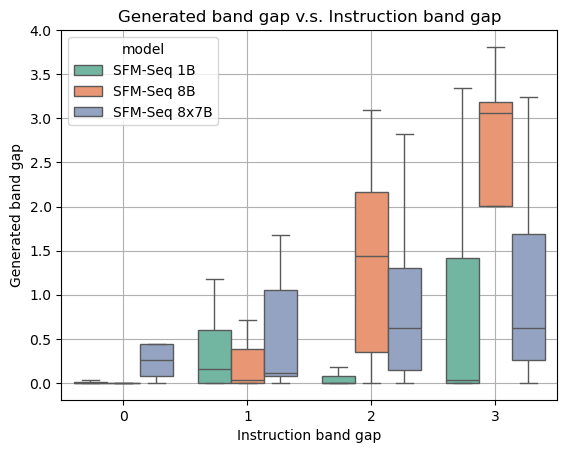

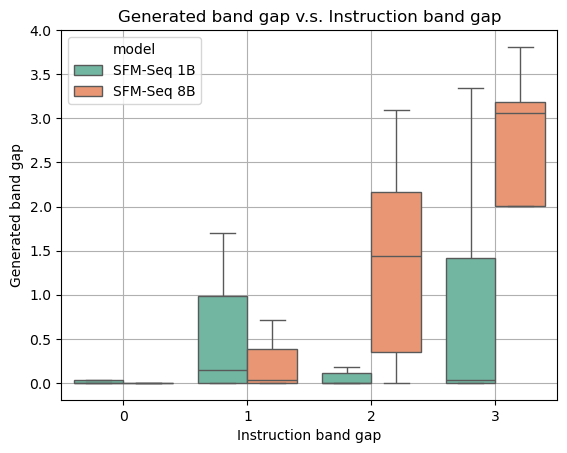

In [26]:
plot_all()
plot_all(novelty=True)

/tmp/ipykernel_3502351/4050159722.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Instruction band gap", y="Generated band gap", data=df, palette="Set2", legend=False)


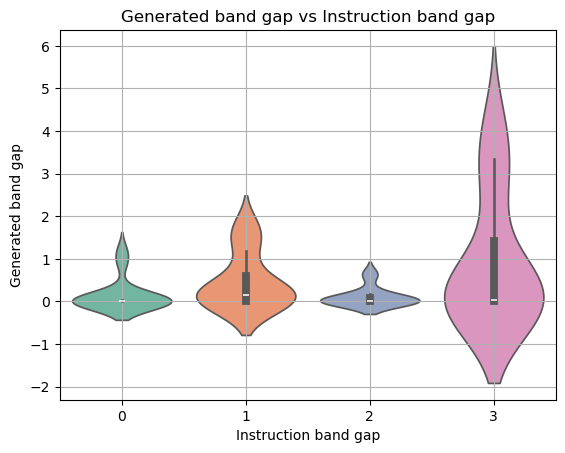

/tmp/ipykernel_3502351/4050159722.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Instruction band gap", y="Generated band gap", data=df, palette="Set2", legend=False)


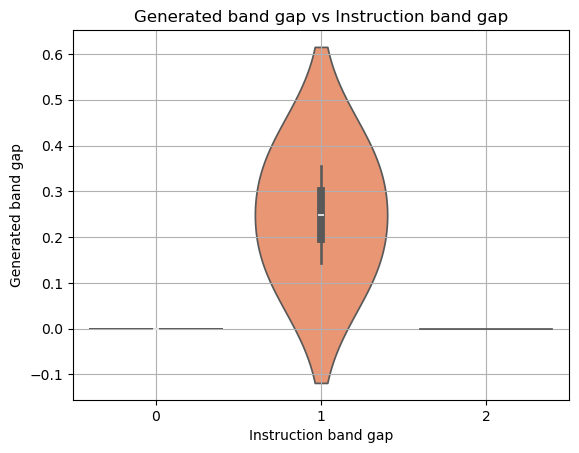

Total: 85
Novel: 19
Novel rate: 19/85 = 0.22


In [13]:
plot(0)
plot(0, novelty=True)

/tmp/ipykernel_3502351/4050159722.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Instruction band gap", y="Generated band gap", data=df, palette="Set2", legend=False)


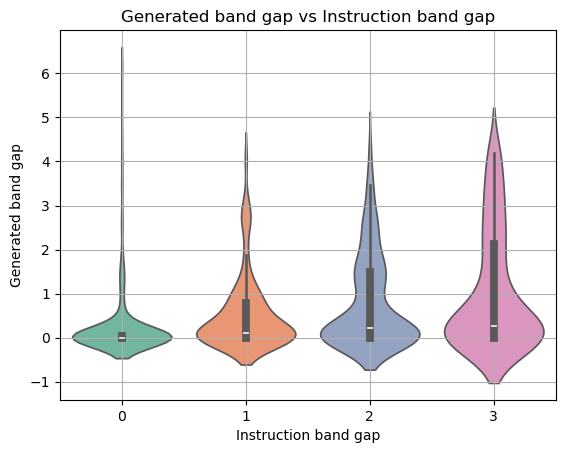

/tmp/ipykernel_3502351/4050159722.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Instruction band gap", y="Generated band gap", data=df, palette="Set2", legend=False)


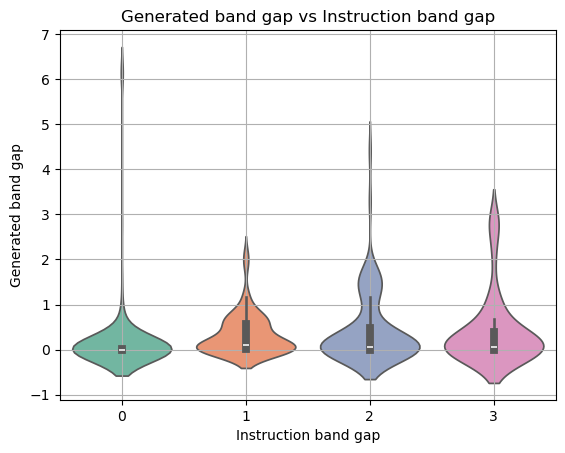

Total: 1288
Novel: 446
Novel rate: 446/1288 = 0.35


In [14]:
plot(1)
plot(1, novelty=True)

/tmp/ipykernel_3502351/4050159722.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Instruction band gap", y="Generated band gap", data=df, palette="Set2", legend=False)


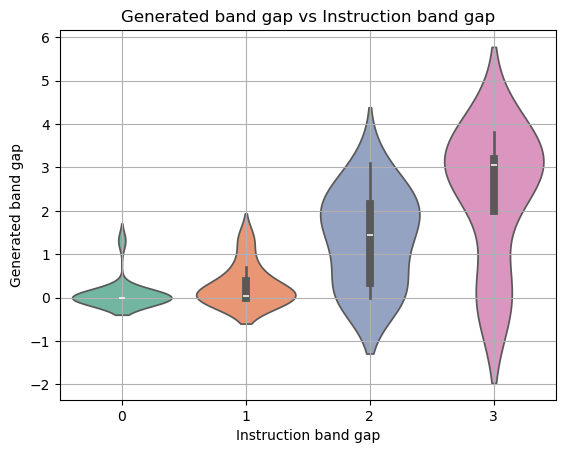

/tmp/ipykernel_3502351/4050159722.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Instruction band gap", y="Generated band gap", data=df, palette="Set2", legend=False)


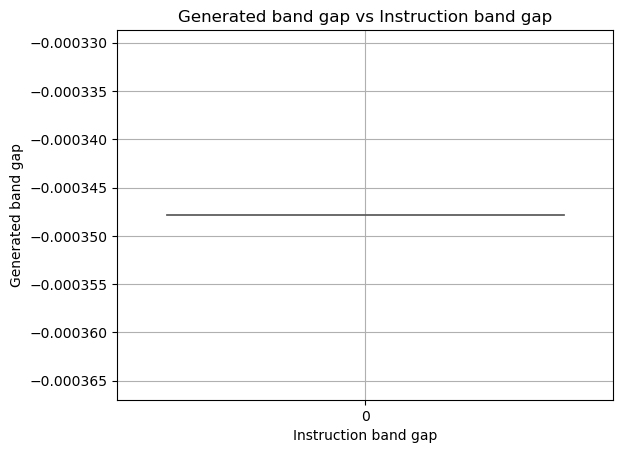

Total: 117
Novel: 10
Novel rate: 10/117 = 0.09


In [15]:
plot(2)
plot(2, novelty=True)

/tmp/ipykernel_3502351/4050159722.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Instruction band gap", y="Generated band gap", data=df, palette="Set2", legend=False)


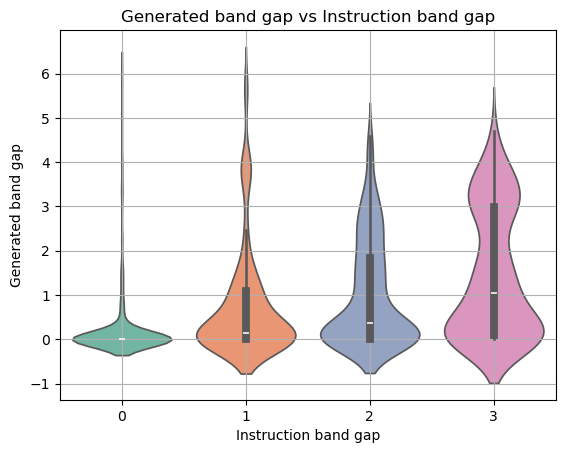

/tmp/ipykernel_3502351/4050159722.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Instruction band gap", y="Generated band gap", data=df, palette="Set2", legend=False)


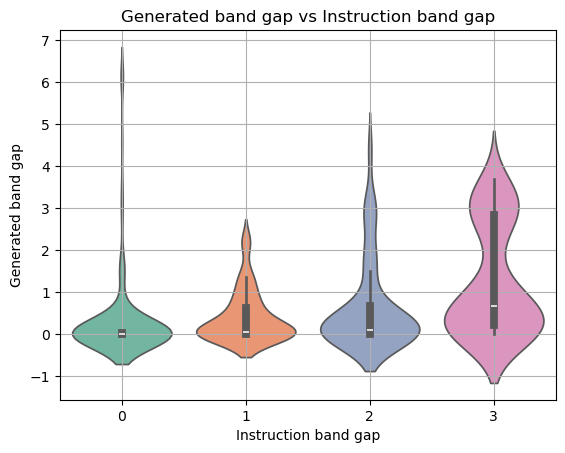

Total: 2886
Novel: 489
Novel rate: 489/2886 = 0.17


In [17]:
plot(3)
plot(3, novelty=True)

/tmp/ipykernel_3965871/577846204.py:188: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Instruction band gap", y="Generated band gap", data=df, palette="Set2", legend=False)


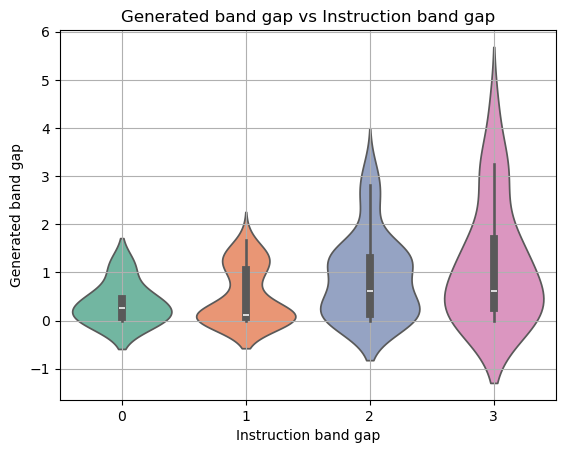

/tmp/ipykernel_3965871/577846204.py:188: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Instruction band gap", y="Generated band gap", data=df, palette="Set2", legend=False)


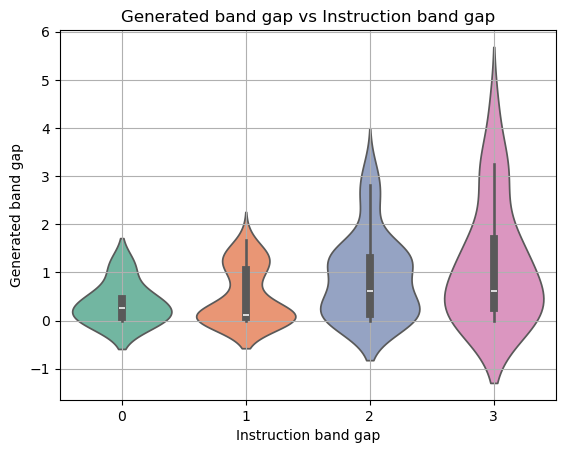

Total: 328
Novel: 328
Novel rate: 328/328 = 1.00


In [12]:
plot(4)
plot(4, novelty=True)